#### env setup

In [1]:
# data processing pkgs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# modeling pkgs

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, auc

In [5]:
# modeling pkgs
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import AUC

In [6]:
# util libs

import warnings
warnings.filterwarnings(action="ignore")

In [178]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%pwd

'd:\\git\\movie-review-sentiment-analysis\\code'

In [8]:
%ls

 Volume in drive D is New Volume
 Volume Serial Number is 744F-189F

 Directory of d:\git\movie-review-sentiment-analysis\code

05/17/2024  03:35 PM    <DIR>          .
05/17/2024  03:35 PM    <DIR>          ..
05/17/2024  03:35 PM             4,481 00_data_extract.ipynb
05/17/2024  03:35 PM            24,329 01_data_processing_MusicRecommendation.ipynb
05/17/2024  03:35 PM           330,444 01_data_transformation.ipynb
05/17/2024  03:35 PM           939,840 02_EDA_MoviesSentimentAnalysis.ipynb
05/17/2024  03:35 PM            74,594 SparkML_Movies_Sentiment_Analysis.ipynb
05/17/2024  03:35 PM           519,562 TraditionalML_MovieSentimentAnalysis.ipynb
               6 File(s)      1,893,250 bytes
               2 Dir(s)  54,861,996,032 bytes free


# read data
Dataset: [https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [11]:
# file path
file_path = "../data/IMDB_reviews_dataset.csv"

In [12]:
# read data
df = pd.read_csv(file_path)

In [13]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Text cleaning

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

In [16]:
# remove stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [17]:
text_cleaned = df.copy()

In [18]:
# convert text to lower

text_cleaned['clean_review'] = text_cleaned.review.str.lower()

Text(0.5, 1.0, 'Distribution of review length')

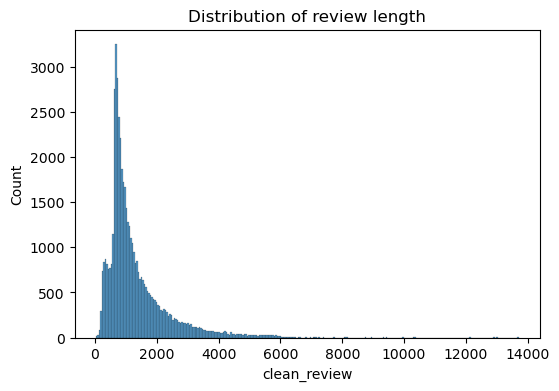

In [19]:
# plot distribution of text length

plt.figure(figsize=(6, 4))
sns.histplot(text_cleaned.clean_review.apply(lambda x:len(x)))
plt.title("Distribution of review length")

In [20]:
# find html like instances in text
pattern = r'<.*?>'
text_cleaned['tag_count'] = text_cleaned['clean_review'].str.count(pattern)

In [21]:
text_cleaned.sample(10)

,review,sentiment,clean_review,tag_count
5441,Sometimes a movie cannot easily be classified....,negative,sometimes a movie cannot easily be classified....,0
31855,...the last time I laughed this much. It's a t...,positive,...the last time i laughed this much. it's a t...,4
31257,One of the worst films I have ever seen. Got s...,negative,one of the worst films i have ever seen. got s...,2
23502,After seeing this film at the SF Independent F...,positive,after seeing this film at the sf independent f...,0
18078,"""Der Todesking"" is not exactly the type of fil...",positive,"""der todesking"" is not exactly the type of fil...",0
29869,my friends and i watched this movie last night...,negative,my friends and i watched this movie last night...,6
34084,I saw the original rough screen showing 4 time...,positive,i saw the original rough screen showing 4 time...,8
20727,I have to say I totally loved the movie. It ha...,positive,i have to say i totally loved the movie. it ha...,0
25088,"Of all the films I have seen, this one, The Ra...",negative,"of all the films i have seen, this one, the ra...",2
27395,"Citizen X tells the story of Andrei Chikatilo,...",positive,"citizen x tells the story of andrei chikatilo,...",4


In [22]:
pattern = r'<(.*?)>'

text_cleaned['tags'] = text_cleaned['clean_review'].str.extractall(pattern)[0].groupby(level=0).apply(list)

In [23]:
exploded_df = text_cleaned.explode('tags')

# Get unique levels from the 'tags' column
unique_tags = exploded_df['tags'].unique()

In [24]:
# create custom stop words based on HTML tags
custom_stop_words = [i for i in unique_tags if len(str(i)) < 7]

In [25]:
custom_stop_words += [i for i in unique_tags if i not in custom_stop_words][:4]

In [26]:
custom_stop_words += ['br']

In [27]:
stop_words[-1]

"wouldn't"

In [28]:
# add custom stop words to stop_words list

stop_words += custom_stop_words

In [29]:
# tokenize data
tokenized_doc = text_cleaned['clean_review'].apply(lambda x: x.split())

In [30]:
tokenized_doc.head()

0    [one, of, the, other, reviewers, has, mentione...
1    [a, wonderful, little, production., <br, /><br...
2    [i, thought, this, was, a, wonderful, way, to,...
3    [basically, there's, a, family, where, a, litt...
4    [petter, mattei's, "love, in, the, time, of, m...
Name: clean_review, dtype: object

In [31]:
len(tokenized_doc)

50000

In [32]:
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [33]:
# save tokens as words

text_cleaned['clean_review'] = tokenized_doc.astype(str).str.replace('\[|\]|\'', '')

In [34]:
# remove , from the tokens

text_cleaned['clean_review'] = text_cleaned.clean_review.str.replace(",",'')

In [35]:
# remove numbers from the text

text_cleaned['clean_review'] = text_cleaned['clean_review'].str.replace(r'\d+','')


In [36]:
# Remove punctuation from the 'text' column
text_cleaned['clean_review'] = text_cleaned['clean_review'].str.replace(f"[{string.punctuation}]", "")

In [37]:
# remove all characters that are not word characters

text_cleaned['clean_review'] = text_cleaned['clean_review'].str.replace(r'[^\w\s]', '')

In [38]:
text_cleaned.sample(5)

,review,sentiment,clean_review,tag_count,tags
17685,The story takes place on the streets of Sao Pa...,positive,['story' 'takes' 'place' 'streets' 'sao' 'paou...,4,"[br /, br /, br /, br /]"
4554,"""Xizao"", is the tale about the clash of modern...",positive,"['""xizao""' 'tale' 'clash' 'modern' 'life' 'anc...",12,"[br /, br /, br /, br /, br /, br /, br /, br ..."
13259,"Caddyshack 2 has a dreadful reputation, due on...",positive,['caddyshack' '2' 'dreadful' 'reputation' 'due...,12,"[br /, br /, br /, br /, br /, br /, br /, br ..."
39994,Family Guy has to be my all time favorite cart...,positive,['family' 'guy' 'time' 'favorite' 'cartoon.it'...,2,"[br /, br /]"
34512,I've never actually seen this film but can tel...,negative,"[""i've"" 'never' 'actually' 'seen' 'film' 'tell...",0,NaN


<Axes: title={'center': 'Top 20 Frequent Number Of Words'}>

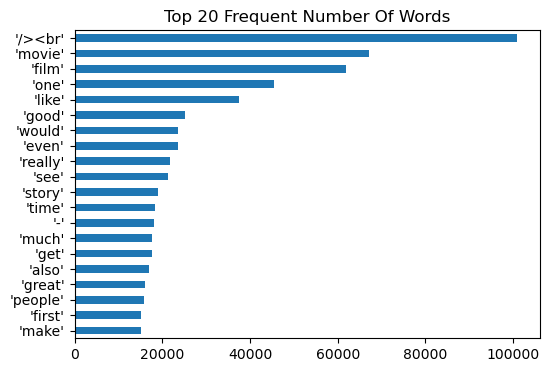

In [41]:
plt.figure(figsize=(6, 4))
most_freq_words = pd.Series(" ".join(text_cleaned['clean_review']).split()).value_counts()
most_freq_words.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Number Of Words")

In [42]:
df = text_cleaned.copy()

In [43]:
df['review'] = df.clean_review

# Logitstic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
RANDOM_STATE = 42

In [46]:
# encode target variable for model to understand

label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])
df.head()


,review,sentiment,clean_review,tag_count,tags,sentiment_encoded
0,['one' 'reviewers' 'mentioned' 'watching' '1' ...,positive,['one' 'reviewers' 'mentioned' 'watching' '1' ...,6,"[br /, br /, br /, br /, br /, br /]",1
1,['wonderful' 'little' 'production.' '<br' '/><...,positive,['wonderful' 'little' 'production.' '<br' '/><...,6,"[br /, br /, br /, br /, br /, br /]",1
2,['thought' 'wonderful' 'way' 'spend' 'time' 'h...,positive,['thought' 'wonderful' 'way' 'spend' 'time' 'h...,4,"[br /, br /, br /, br /]",1
3,"['basically' ""there's"" 'family' 'little' 'boy'...",negative,"['basically' ""there's"" 'family' 'little' 'boy'...",6,"[br /, br /, br /, br /, br /, br /]",0
4,"['petter' ""mattei's"" '""love' 'time' 'money""' '...",positive,"['petter' ""mattei's"" '""love' 'time' 'money""' '...",8,"[br /, br /, br /, br /, br /, br /, br /, br /]",1


In [47]:
# split the data in train test

X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment_encoded'].values,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [48]:
# extract features from text

vectorizer = TfidfVectorizer(max_features=500, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [49]:
# define model

log_model = LogisticRegression()

In [50]:
# fit on train

log_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [51]:
# evaluate model

test_preds = log_model.predict(X_test_tfidf)

f1score = f1_score(y_test, test_preds)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, test_preds)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, test_preds)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, test_preds)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

F1-Score on Test Set: 0.84
Precision on Test Set: 0.83
Recall on Test Set: 0.85
Accuracy on Test Set: 0.84
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4961
           1       0.83      0.85      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix:
[[4110  851]
 [ 741 4298]]


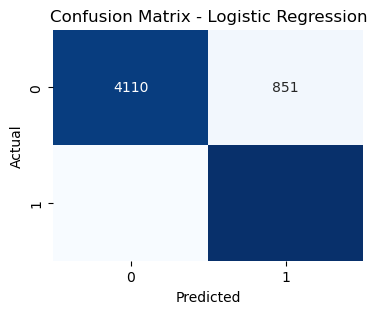

In [61]:
# plot confusion matrix
plt.figure(figsize=(4, 3))
conf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

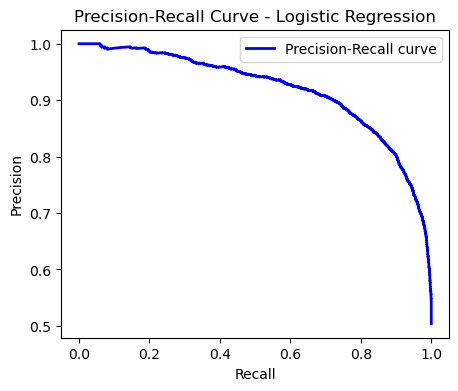

In [74]:
# get precision recall curve

test_proba = log_model.predict_proba(X_test_tfidf)

precision, recall, _ = precision_recall_curve(y_test, test_proba[:, 1])

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='best')

In [75]:
log_model_metrics = {'model':"logistic_regression",
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}

# SVM Model

In [76]:
# param_grid = {
#     'C': [0.1, 1, 10, 100],          # Regularization parameter
#     'gamma': [0.01, 0.1, 1, 'auto'], # Kernel coefficient
# }

In [77]:
## best params from previous run
params = {'C':0.1, 'gamma':0.1}

In [78]:
svm_model = SVC(**params, kernel="rbf", random_state=RANDOM_STATE, probability=True)

In [79]:
# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=svm_model,
#                            param_grid=param_grid,
#                            scoring='f1',cv=2, verbose=1, n_jobs=-1)

In [80]:
# # Perform grid search
# grid_search.fit(X_train_tfidf, y_train)

In [81]:
# grid_search.best_params_
# {'C':0.1, 'gamma':0.1}

In [82]:
# best_svm_model = grid_search.best_estimator_

In [83]:
# fit data on best model

svm_model.fit(X_train_tfidf, y_train)

SVC(C=0.1, gamma=0.1, probability=True, random_state=42)

In [84]:
svm_model

SVC(C=0.1, gamma=0.1, probability=True, random_state=42)

In [85]:
# evaluate model

test_preds = svm_model.predict(X_test_tfidf)

f1score = f1_score(y_test, test_preds)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, test_preds)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, test_preds)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, test_preds)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

F1-Score on Test Set: 0.83
Precision on Test Set: 0.81
Recall on Test Set: 0.86
Accuracy on Test Set: 0.83
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      4961
           1       0.81      0.86      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
[[3914 1047]
 [ 681 4358]]


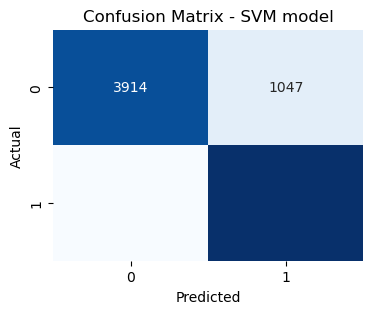

In [86]:
# plot confusion matrix
plt.figure(figsize=(4, 3))
conf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM model')
plt.show()

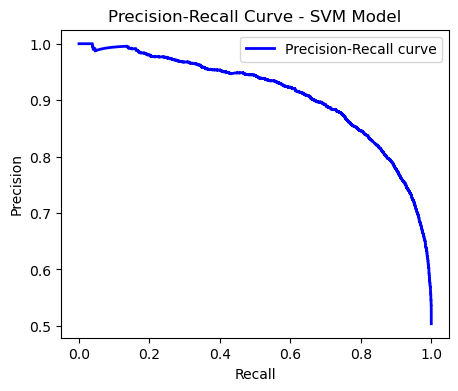

In [87]:
# get precision recall curve

test_proba = svm_model.predict_proba(X_test_tfidf)

precision, recall, _ = precision_recall_curve(y_test, test_proba[:, 1])

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model')
plt.legend(loc='best')
plt.show()

In [88]:
svm_model_metrics = {'model':"svm_model",
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}

# XGBoost Model

In [89]:
# define model with best parameters

model_XGB = XGBClassifier(n_estimators=200, learning_rate=0.2, max_depth = 3, objective='binary:logistic')

In [90]:

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'gamma': [0, 0.1, 0.2],

# }

# # Create the XGBoost model
# model_XGB = XGBClassifier(objective='binary:logistic')

# # Create GridSearchCV object
# grid_search = GridSearchCV(model_XGB, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# # Perform grid search
# grid_result = grid_search.fit(X_train_tfidf, y_train)

# # Print the best parameters and corresponding accuracy
# print("Best Parameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

# # Get the best model
# best_model = grid_result.best_estimator_

# # Make predictions on the test set using the best model
# y_pred = best_model.predict(X_test_tfidf)

# # Evaluate the best model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy on Test Set: {accuracy:.2f}')

# # Print classification report and confusion matrix for the best model
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

In [91]:
# fit model
model_XGB.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [92]:
# evaluate model

# Make predictions on the test set
test_preds = model_XGB.predict(X_test_tfidf)

f1score = f1_score(y_test, test_preds)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, test_preds)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, test_preds)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, test_preds)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

F1-Score on Test Set: 0.83
Precision on Test Set: 0.81
Recall on Test Set: 0.86
Accuracy on Test Set: 0.83
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      4961
           1       0.81      0.86      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
[[3969  992]
 [ 723 4316]]


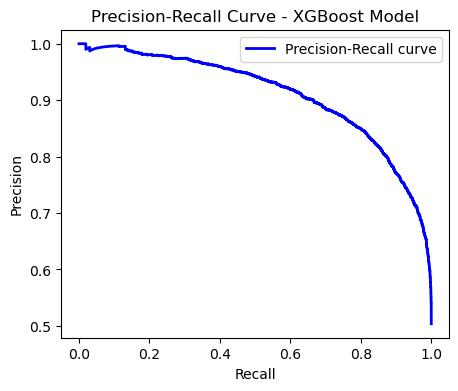

In [93]:
from sklearn.metrics import precision_recall_curve

pred_proba = model_XGB.predict_proba(X_test_tfidf)
precision, recall, _ = precision_recall_curve(y_test, pred_proba[:,1])

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Model')
plt.legend(loc='best')
plt.show()


# Deep Learning model

In [94]:
df.head()

,review,sentiment,clean_review,tag_count,tags,sentiment_encoded
0,['one' 'reviewers' 'mentioned' 'watching' '1' ...,positive,['one' 'reviewers' 'mentioned' 'watching' '1' ...,6,"[br /, br /, br /, br /, br /, br /]",1
1,['wonderful' 'little' 'production.' '<br' '/><...,positive,['wonderful' 'little' 'production.' '<br' '/><...,6,"[br /, br /, br /, br /, br /, br /]",1
2,['thought' 'wonderful' 'way' 'spend' 'time' 'h...,positive,['thought' 'wonderful' 'way' 'spend' 'time' 'h...,4,"[br /, br /, br /, br /]",1
3,"['basically' ""there's"" 'family' 'little' 'boy'...",negative,"['basically' ""there's"" 'family' 'little' 'boy'...",6,"[br /, br /, br /, br /, br /, br /]",0
4,"['petter' ""mattei's"" '""love' 'time' 'money""' '...",positive,"['petter' ""mattei's"" '""love' 'time' 'money""' '...",8,"[br /, br /, br /, br /, br /, br /, br /, br /]",1


In [95]:
# pad features

MAX_LENGTH = 400
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
df['padded_review_tokens'] = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(df['padded_review_tokens'], maxlen=MAX_LENGTH, padding='post', truncating='post')

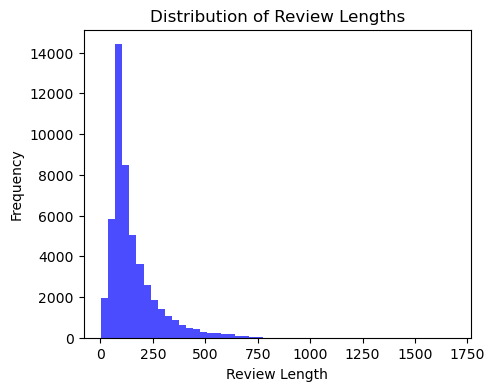

In [97]:
# plot distribution of review length

df['review_length'] = df['padded_review_tokens'].apply(len)

# Plot the length of each review
plt.figure(figsize=(5, 4))
plt.hist(df['review_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()



In [98]:
# split data into train test

X_train, X_test, y_train, y_test = train_test_split(padded_sequences,
                                                    df['sentiment_encoded'].values,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [99]:
# define model

mode_lstm = Sequential()
mode_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=MAX_LENGTH))
# early_stopping = EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1, restore_best_weights=True)
mode_lstm.add(LSTM(100, return_sequences=True))
mode_lstm.add(GlobalMaxPooling1D())
mode_lstm.add(Dense(64, activation='relu'))
mode_lstm.add(Dense(1, activation='sigmoid'))

mode_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

history = mode_lstm.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 235s 230ms/step - auc: 0.7924 - loss: 0.5096 - val_auc: 0.9558 - val_loss: 0.2702
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 284s 285ms/step - auc: 0.9897 - loss: 0.1203 - val_auc: 0.9506 - val_loss: 0.3538
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 298s 298ms/step - auc: 0.9987 - loss: 0.0342 - val_auc: 0.9409 - val_loss: 0.4313


In [100]:
mode_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 400, 50)          │     9,384,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 400, 100)         │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (32, 100)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353,239 (108.16 MB)

 Trainable params: 9,451,079 (36.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,902,160 (72.11 MB)

In [102]:
history.history['auc']

[0.9063050150871277, 0.9889587163925171, 0.9985528588294983]

In [106]:
history.history

{'auc': [0.9063050150871277, 0.9889587163925171, 0.9985528588294983],
 'loss': [0.3848441541194916, 0.1272052675485611, 0.03683250769972801],
 'val_auc': [0.9557844996452332, 0.9506452679634094, 0.9409314393997192],
 'val_loss': [0.27020514011383057, 0.3537929356098175, 0.43130043148994446]}

In [110]:
# evaluate model

loss, accuracy = mode_lstm.evaluate(X_test, y_test)
print(f'Accuracy on Test Set: {accuracy:.2f}')

y_pred_DL = mode_lstm.predict(X_test)
y_pred_binary = (y_pred_DL > 0.5).astype(int)

f1score = f1_score(y_test, y_pred_binary)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, y_pred_binary)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, y_pred_binary)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, y_pred_binary))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - auc: 0.9452 - loss: 0.4106
Accuracy on Test Set: 0.94
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step
F1-Score on Test Set: 0.88
Precision on Test Set: 0.91
Recall on Test Set: 0.86
Accuracy on Test Set: 0.88
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4961
           1       0.91      0.86      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

Confusion Matrix:
[[4510  451]
 [ 703 4336]]


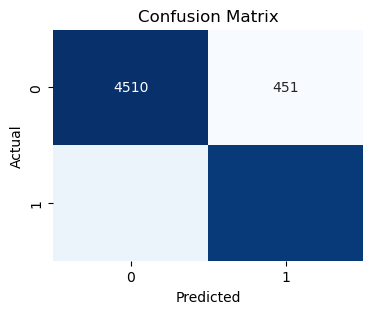

In [111]:
plt.figure(figsize=(4, 3))
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

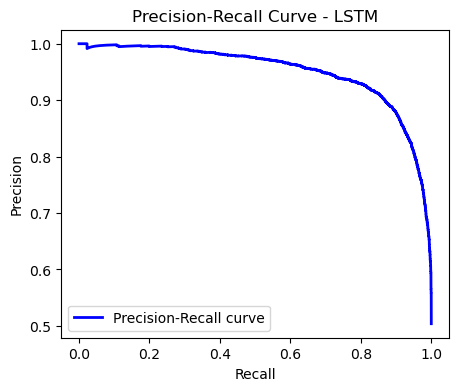

In [112]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_DL)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LSTM')
plt.legend(loc='best')
plt.show()

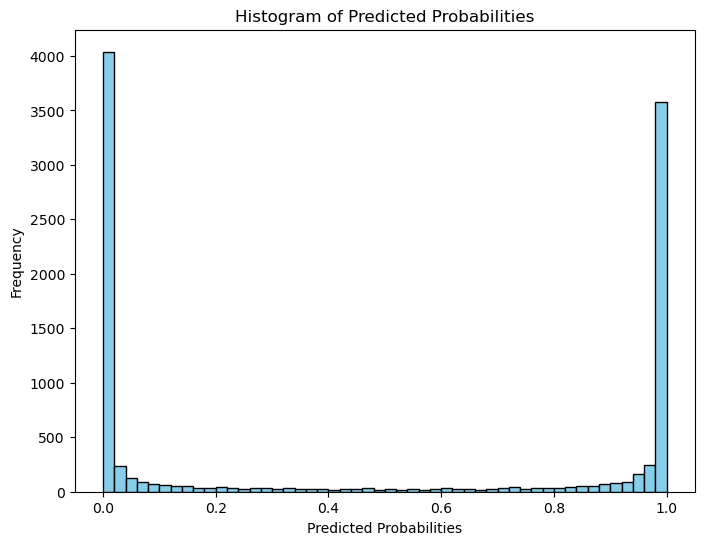

In [113]:
plt.figure(figsize=(8, 6))
plt.hist(y_pred_DL, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

In [114]:
dl_model_metrics = {'model':"deep_learning",
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}

# results

In [115]:
models = [log_model, svm_model, model_XGB]

In [116]:
model_metrics_obj = []

In [117]:
for model in models:
  preds = model.predict(X_test_tfidf)
  f1score = f1_score(y_test, preds)

  pr_score = precision_score(y_test, preds)
  rec_score = recall_score(y_test, preds)

  acc_score = accuracy_score(y_test, preds)

  model_metrics = {'model':model,
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}
  model_metrics_obj.append(model_metrics)

In [127]:
dl_model_metrics

{'model': 'deep_learning',
 'f1_score': 0.8825564828007327,
 'precision': 0.9057865051180279,
 'recall': 0.8604881921016074,
 'accuracy': 0.8846}

In [131]:
list(dl_model_metrics.keys())

['model', 'f1_score', 'precision', 'recall', 'accuracy']

In [140]:
dl_metrics_df = pd.DataFrame(data=dl_model_metrics, index=[0])

In [141]:
results_df = pd.DataFrame(model_metrics_obj)

In [142]:
results_df

,model,f1_score,precision,recall,accuracy
0,LogisticRegression(),0.843738,0.834725,0.852947,0.8408
1,"SVC(C=0.1, gamma=0.1, probability=True, random...",0.834546,0.806290,0.864854,0.8272
2,"XGBClassifier(base_score=None, booster=None, c...",0.834251,0.813112,0.856519,0.8285


,model,f1_score,precision,recall,accuracy
0,LogisticRegression(),0.843738,0.834725,0.852947,0.8408
1,"SVC(C=0.1, gamma=0.1, probability=True, random...",0.834546,0.806290,0.864854,0.8272
2,"XGBClassifier(base_score=None, booster=None, c...",0.834251,0.813112,0.856519,0.8285
0,deep_learning,0.882556,0.905787,0.860488,0.8846


In [147]:
results_df = pd.concat([results_df, dl_metrics_df], ignore_index=False)

In [148]:
results_df.sort_values("f1_score", ascending=False)

,model,f1_score,precision,recall,accuracy
0,deep_learning,0.882556,0.905787,0.860488,0.8846
0,LogisticRegression(),0.843738,0.834725,0.852947,0.8408
1,"SVC(C=0.1, gamma=0.1, probability=True, random...",0.834546,0.806290,0.864854,0.8272
2,"XGBClassifier(base_score=None, booster=None, c...",0.834251,0.813112,0.856519,0.8285


In [150]:
 models = [log_model, svm_model, model_XGB]

In [166]:
prec_rec_df = pd.DataFrame()

for mod in models:
  print(f"Predicting for {mod} model")
  pred_proba = mod.predict_proba(X_test_tfidf)
  df_vals = pd.DataFrame({"model":mod,"true": y_test, "preds":pred_proba[:, 1]})
  prec_rec_df = pd.concat([prec_rec_df, df_vals])

Predicting for LogisticRegression() model
Predicting for SVC(C=0.1, gamma=0.1, probability=True, random_state=42) model
Predicting for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model


In [167]:
y_pred_DL = mode_lstm.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step


In [168]:
mode_lstm.name

'sequential'

In [169]:
df_vals = pd.DataFrame({"model":"LSTM","true": y_test, "preds":y_pred_DL.flatten()})

In [170]:
prec_rec_df = pd.concat([prec_rec_df, df_vals])

In [171]:
# get model name as text
prec_rec_df.model = [str(i).split("(")[0] for i in prec_rec_df.model]
prec_rec_df.model = [str(i).split(".")[0] for i in prec_rec_df.model]
prec_rec_df.model = np.where(prec_rec_df.model.isin(['<keras']), "LSTM", prec_rec_df.model)

In [172]:
grp_df = prec_rec_df.groupby("model")

In [173]:
prec_rec_df.model.unique()

array(['LogisticRegression', 'SVC', 'XGBClassifier', 'LSTM'], dtype=object)

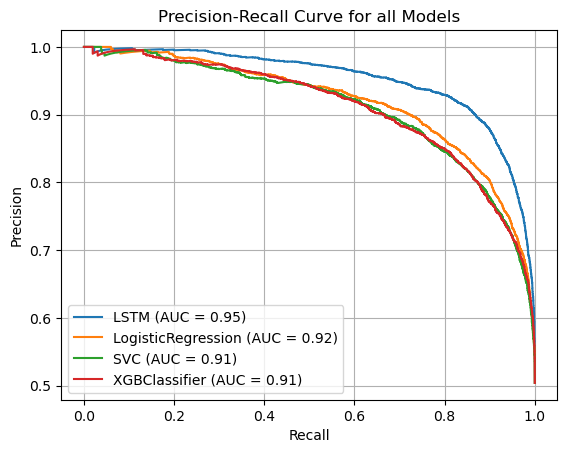

In [174]:
for group in grp_df.groups:
  tmp_df = grp_df.get_group(group)
  precision, recall, thresholds = precision_recall_curve(tmp_df['true'], tmp_df['preds'])
  area = auc(recall, precision)

  plt.plot(recall, precision, label=f'{group} (AUC = {area:.2f})')
  plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for all Models')
plt.grid(True)

In [176]:
mode_lstm.save("../results/model/best_lstm_model_sentiment_classifier.keras")